In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim, utils
import torch.nn.init as init
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision as tv
from torchvision import datasets, transforms
from torchsummary import summary

device = torch.device('cuda:0')
print("Device: ", device)

datapath = '/raid/artem/tmp'

Device:  cuda:0


In [2]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

In [3]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [4]:
z_dim = 100
batch_size = 600

tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize(mean=(0.5,), std=(0.5,))])
target = datasets.MNIST(root=datapath,
                        train=True,
                        transform=tfms,
                        download=True)

#target = datasets.SVHN(root=datapath,
#                       split='train',
#                       transform=tfms,
#                       download=True)

dataloader = utils.data.DataLoader(dataset=target,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   drop_last=True)
print("Number of batches:", len(dataloader))

Number of batches: 100


Batch shape:  torch.Size([600, 1, 28, 28])


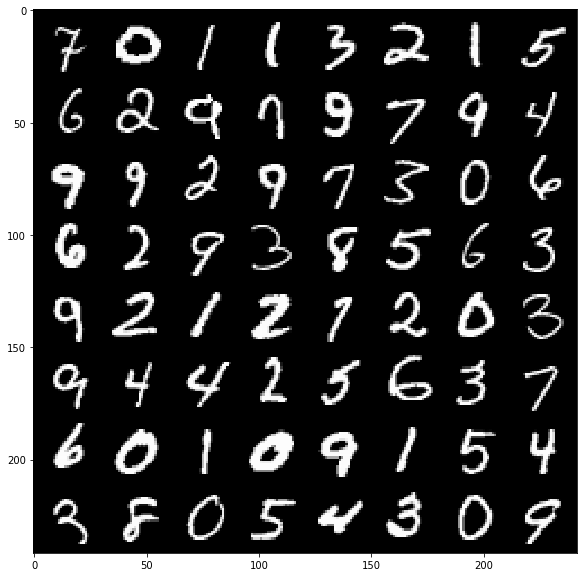

In [5]:
i, (x, y) = next(enumerate(dataloader))
print("Batch shape: ", x.shape)

plt.figure(figsize=(10,10))
plt.imshow(tv.utils.make_grid(x[:64], normalize=True).permute(1, 2, 0)); plt.show()

In [6]:
target_dim = target.train_data.size(1)*target.train_data.size(2)
#target_dim = target.data.shape[2]*target.data.shape[3]#*target.data.shape[1]

G = Generator(input_dim = z_dim, output_dim = target_dim, hidden_dim=256).to(device)
print("Generator: ")
summary(G, (1, z_dim))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Generator: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]          25,856
            Linear-2               [-1, 1, 512]         131,584
            Linear-3              [-1, 1, 1024]         525,312
            Linear-4               [-1, 1, 784]         803,600
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 5.67
Estimated Total Size (MB): 5.69
----------------------------------------------------------------


In [7]:
D = Discriminator(target_dim, hidden_dim=1024).to(device)
print("Discriminator: ")
summary(D, (1, target_dim))

Discriminator: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]         803,840
            Linear-2               [-1, 1, 512]         524,800
            Linear-3               [-1, 1, 256]         131,328
            Linear-4                 [-1, 1, 1]             257
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 5.57
Estimated Total Size (MB): 5.59
----------------------------------------------------------------


In [8]:
criterion = nn.BCELoss()
g_lr = 0.0002
d_lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = g_lr)
D_optimizer = optim.Adam(D.parameters(), lr = d_lr)

In [9]:
epochs = 100

D_losses = []
G_losses = []
for epoch in range(1, epochs+1):
    for idx, (x, _) in enumerate(dataloader):
        #if idx == 1: break
        
        D.zero_grad()
        x_real = Variable(x.view(-1, target_dim).to(device))
        y_real = Variable(torch.ones(batch_size, 1).to(device))
        z = Variable(torch.randn(batch_size, z_dim).to(device))
        x_fake = G(z)
        y_fake = Variable(torch.zeros(batch_size, 1).to(device))
        D_loss = criterion(D(x_real), y_real) + criterion(D(x_fake), y_fake)
        D_loss.backward()
        D_optimizer.step()
        D_losses.append(D_loss)
        
        G.zero_grad()
        z = Variable(torch.randn(batch_size, z_dim).to(device))
        y = Variable(torch.ones(batch_size, 1).to(device))
        
        G_loss = criterion(D(G(z)), y)
        G_loss.backward()
        G_optimizer.step()
        G_losses.append(G_loss)
        
    if not (epoch % 10):
        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' %
              ((epoch), epochs,
               torch.mean(torch.FloatTensor(D_losses)),
               torch.mean(torch.FloatTensor(G_losses))))

[10/100]: loss_d: 0.747, loss_g: 3.667
[20/100]: loss_d: 0.601, loss_g: 3.726
[30/100]: loss_d: 0.524, loss_g: 3.867
[40/100]: loss_d: 0.489, loss_g: 3.845
[50/100]: loss_d: 0.480, loss_g: 3.747
[60/100]: loss_d: 0.470, loss_g: 3.672
[70/100]: loss_d: 0.479, loss_g: 3.564
[80/100]: loss_d: 0.489, loss_g: 3.463
[90/100]: loss_d: 0.501, loss_g: 3.360
[100/100]: loss_d: 0.517, loss_g: 3.261


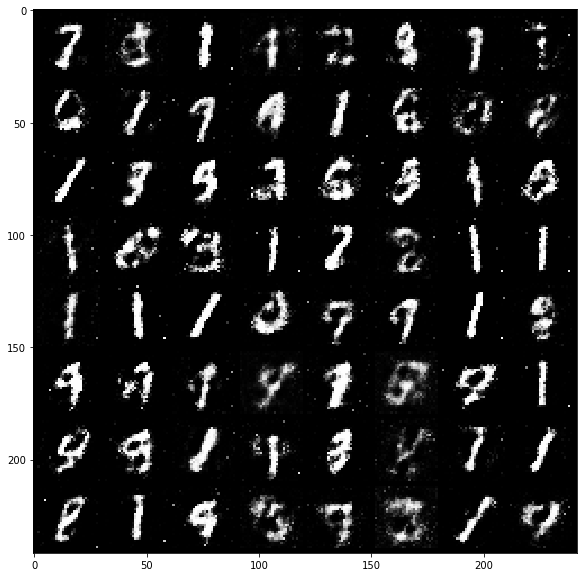

In [10]:
z = Variable(torch.randn(batch_size, z_dim).to(device))
x = G(z).detach().cpu()
x = np.reshape(x, (x.shape[0], 1, 28, 28))

plt.figure(figsize=(10,10))
plt.imshow(tv.utils.make_grid(x[:64], normalize=True).permute(1, 2, 0)); plt.show()